In [2]:
pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import pickle as pkl
import sys
import matplotlib.gridspec as gridspec
from scipy import optimize
import matplotlib.pyplot as plt
try:
    os.environ['SESNPATH']
    os.environ['SESNCFAlib']

except KeyError:
    print ("must set environmental variable SESNPATH and SESNCfAlib")
    sys.exit()

cmd_folder = os.getenv("SESNCFAlib")
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
cmd_folder = os.getenv("SESNCFAlib") + "/templates"
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from savgol import savitzky_golay
from snclasses import *
import templutils as templutils
# from makePhottable import *
# from colors import rgb_to_hex
# from ubertemplates import *
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, MaxNLocator

from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.mlab as mlab
from select_lc import *
from Functions import *
import pandas as pd

In [2]:
SNTYPES = ['Ib','IIb','Ic','Ic-bl', 'Ibn']

bands = ['R','V','r','g','U','u','J','B','H','I','i','K','m2','w1','w2']
colorTypes = {'IIb':'FireBrick',
             'Ib':'SteelBlue',
             'Ic':'DarkGreen',
             'Ic-bl':'DarkOrange',
             'Ibn':'purple'}

In [3]:
# latex_tp = {'Ib': r'$\rom{{{}}}\mathrm{b}$'.format(1),
#            'IIb': r'$\rom{{{}}}\mathrm{b}$'.format(2),
#            'Ic': r'$\rom{{{}}}\mathrm{c}$'.format(1),
#            'Ic-bl': r'$\rom{{{}}}\mathrm{c-bl}$'.format(1),
#            'Ibn': r'$\rom{{{}}}\mathrm{bn}$'.format(1)}

In [4]:
lsst_bands = {'0':'u',
              '1':'g',
              '2': 'r',
              '3': 'i',
              '4': 'z',
              '5': 'y'}

clrs =  {'0':'b',
              '1':'g',
              '2': 'r',
              '3': 'purple',
              '4': 'cyan',
              '5': 'k'}
su = templutils.setupvars()
coffset = su.coffset

ref = coffset['r']
for b in coffset.keys():
    coffset[b] = coffset[b] - ref

In [5]:
tmpl = {}

for bb in bands:

    tmpl[bb] = {}

    for SNTYPE in SNTYPES:
        
        tmpl[bb][SNTYPE] = {}



        try:
            path = "outputs/GPs_2022/GPalltemplfit_%s_%s_V0.pkl"%(SNTYPE,bb)
            tmpl_ = pkl.load(open(path, "rb"))
        except:
            continue
        
#         print(tmpl_['rollingMedian'])

        if np.nansum(tmpl_['rollingMedian']) == 0:
            print(bb, SNTYPE)
            continue

        tmpl[bb][SNTYPE] = tmpl_



In [9]:
df1 = pd.read_csv('plasticc_train_lightcurves.csv') #plasticc_train_lightcurves.csv #./../../../../../../../../Downloads/plasticc_test_set_batch1.csv
df2 = pd.read_csv('plasticc_train_metadata.csv') #plasticc_train_metadata.csv # ./../../../../../../../../Downloads/plasticc_test_metadata.csv

In [10]:
colors = ['SteelBlue', 'g',  'red','purple']

In [11]:
len(df2.object_id[(df2.true_target == 62)].values)

484

In [12]:
SN_Ibc_id = df2.object_id[(df2.true_target == 62) & (df2.true_z <= 0.2)].values

In [13]:
df1 = df1[df1['object_id'].isin(SN_Ibc_id)]
df1 = df1.reset_index(drop = True)

In [14]:
len(SN_Ibc_id)

294

In [17]:
ID_selected = []
bn = 2
for i, ID in enumerate(SN_Ibc_id):
#     print(ID)
    
    t = df1.mjd[(df1.passband == bn)&(df1.object_id == ID)].values
    f = df1.flux[(df1.passband == bn)&(df1.object_id == ID)].values
    ferr = df1.flux_err[(df1.passband == bn)&(df1.object_id == ID)].values
    
#     print(len(f))
    
#     SN = (f/ferr)>5
    
#     if np.sum(SN)<5:
#         print('1')
#         continue
    
#     if (np.argmax(f) == 0) or (np.argmax(f) == -1):
#         print('2')
#         continue
            
    try:
        if ((t[np.argmax(f)]-t[np.argmax(f)-1])>20) or ((t[np.argmax(f)+1]-t[np.argmax(f)])>20):
#             print('3')
            continue
    except:
#         print('4')
        continue
        
        
    ID_selected.append(ID)
    
    


    
    

In [18]:
len(ID_selected)
# # df1.passband


69

In [19]:
bn = 'r'
for i,ID in enumerate(ID_selected):
    
    
    df_r = df1[(df1.object_id == ID) & (df1.passband == bn)].reset_index(drop=True)
    df_new = df1[(df1.object_id == ID) & (df1.passband == bn)].reset_index(drop=True)
#     print(len(df_new))
    df_new = df_new[df_new.flux>0].reset_index(drop=True)
    df_r = df_r[df_r.flux>0].reset_index(drop=True)
    

    if len(df_new.flux)==0:
        print(ID)
        continue
        
    


    df_r['m'] = -2.5*np.log10(df_r.flux/(10**(-0.4*27.5)))
    median = np.nanmedian(df_r['m'])
    df_r['m'] = df_r['m']- median
    df_r['m_err'] = 2.5 / np.log(10) * df_r['flux_err'] / df_r['flux']
    
    df_new['m'] = -2.5*np.log10(df_new.flux/(10**(-0.4*27.5)))
    median = np.nanmedian(df_new['m'])
    df_new['m'] = df_new['m']- median
    df_new['m_err'] = 2.5 / np.log(10) * df_new['flux_err'] / df_new['flux']
    
    
        
    x = df_new.mjd.values
    y = df_new['m'].values
    yerr = df_new['m_err'].values
    
    

3910
11770
18706
19213
29670
34299
39597
42118
49529
56821
64854
69767
81252
87180
161591
183932
190161
190577
190878
195555
197650
199356
203294
218492
230610
232308
263344
292021
305218
307546
331538
332613
340269
4521595
18551356
19451710
34518664
34768808
40179498
43616315
44537206
47232343
50875482
53834212
55976189
57320649
57372172
59287246
63730187
65978932
67112741
74516761
75499040
76395448
77699478
79333412
83278224
90164039
96403793
100012747
104304755
105345794
105640435
113405851
118926278
119547853
123872342
124348848
128839699


In [20]:
# dff = df1[(df1.object_id == 124348848) & (df1.passband == 2)]
# dff.flux/dff.flux_err

In [21]:
# Good lcs: 34299, 49529, 56987, 106434, 162093, 183932, 1909161, 190577, 226704, 235005, 275987, 298802
# good_sn = [34299, 49529, 56987, 106434, 162093, 183932, 190577, 226704, 235005,\
#            275987, 298802, 29670, 99280, 147642, 183932,187216, 190161, 190577,\
#           190878, 197650, 218492, 230227, 232308, 235005, 274498, 292021, 298802]

good_sn = [3910, 11770, 19213,29670, 34299, 49529, 55419, 69767,\
           87180, 152756, 158241, 161591, 162093, 183932, 190161,\
          190577, 190878, 195555, 197559, 197650, 203294, 203563,\
          218492, 227068, 232308, 267965, 274498, 292021, 305218,\
          319554, 331538, 332613, 340269, 1879121, 26842116, 40179498,\
          100012747, 105345794]

good_sn_test = [37, 17, 60, 69, 106, 115, 176, 186, 195, 198, 216,\
                277, 289, 357, 406, 409, 413, 466, 478, 561, 607, 613,\
                622, 674, 686, 687, 694, 721, 729, 731, 734, 830, 833,\
                834, 883, 916, 917, 943, 946, 960, 962, 965, 978, 983, 1017,\
                1018, 1108, 1123, 1128, 1138, 1271, 1288, 1354, 1380, 1393,\
                1467, 1468, 1487, 1498, 1500, 1523, 1536, 1545, 1570, 1578,\
                1597, 1599, 1636, 1667, 1678, 1720, 1754, 1780, 1871, 1999,\
                2017, 2046, 2074, 2109, 2133, 2147, 2246, 2252, 2265, 2281,\
                2351, 2372, 2410, 2451, 2683, 2702, 2794, 2856, 2858, 2886,\
                2909, 2943, 2970, 2975, 3004, 3190, 3206, 3210, 3347, 3395,\
                3499, 3566, 3645, 3737, 3749, 3764, 3777, 3785, 3794, 3821,\
                3928, 3950, 4007, 4025, 4054, 4202, 4216, 4274, 4294, 4313,\
                4322, 4489, 4494, 4525, 4592, 4645, 4695, 4750, 4822, 4866, 4910]

In [22]:
# df1['SN_r'] = np.zeros(len(df1))

# for ID in (IDs):

#     for b in ([bn]):
        
#         df2 = df1[(df1.object_id == ID) & (df1.passband == b)].reset_index(drop=True)
        
        
#         df2 = df2[df2.flux>0].reset_index(drop=True)
        

#         if len(df2.flux)==0:
#             continue
        
#         SN_mean = np.mean(df2.flux/df2.flux_err)
        
#         df1['SN_r'][(df1.object_id == ID) & (df1.passband == b)] =\
#         np.ones(len(df1['SN_r'][(df1.object_id == ID) & (df1.passband == b)]))*SN_mean



In [23]:
bn = 2
high_SN = df1.object_id[df1.passband == bn][df1.flux[df1.passband == bn]/df1.flux_err[df1.passband == bn] > 10].unique()
# high_SN = df1.object_id[df1.passband == bn][df1.SN_r[df1.passband == bn] > 10].unique()

In [24]:
len(high_SN)

205

In [25]:
# plt.hist(df1.SN_r.unique(), bins = 100)
# plt.xlim(-4,5)

In [26]:
IDs = np.asarray(df1.groupby('object_id').size().index)

In [27]:


# print(len(ID_selected))


#[]
# for ID in (high_SN):

#     for b in ([bn]): 
        
#         df2 = df1[(df1.object_id == ID) & (df1.passband == b)].reset_index(drop=True)
        
        
#         df2 = df2[df2.flux>0].reset_index(drop=True)
        

#         if len(df2.flux)==0:
#             continue

        
#         t = df2.mjd-df2.mjd[np.argmax(df2.flux)]

#         if np.argmax(df2.flux)+1 > len(np.diff(t))-1:
#             continue 
#         if np.abs(np.diff(t)[np.argmax(df2.flux)])<5 and\
#            np.abs(np.diff(t)[np.argmax(df2.flux)+1])<5:
        
# #             continue
            
#             ID_selected.append(ID)

#             print(ID)
            
            
#             f.write(lsst_bands[str(b)] + "l" + " " + str("{:.4f}".format(df2.mjd[i])) +\
#                    " " + str("{:.6f}".format(df2.m[i]))+ " "+\
#                    str("{:.6f}".format(df2.m_err[i])) + "\n")
#             f.write(lsst_bands[str(b)] + "l" + " " + str("{:.4f}".format(df2.mjd[i])) +\
#                    " " + str("{:.6f}".format(df2.flux[i]))+ " "+\
#                    str("{:.6f}".format(df2.flux_err[i])) + "\n")
#     f.close()
#         plt.plot(df2.mjd-df2.mjd[np.argmax(df2.flux)],\
#                      -1*df2.m + np.min(df2.m),\
#                      '.', color = 'grey')
#         plt.errorbar(df2.mjd,\
#                      df2.m,\
#                      yerr = df2.m_err,\
#                      marker = 'o', color = colors[b])
#     plt.title('Lc number '+ str(ID) + ' in all bands ')
# plt.xlim(-20,50)
# plt.ylim(-4,0.5)

In [28]:
tmpl = {}



SNTYPES = ['Ib','IIb','Ic','Ic-bl', 'Ibn']
bands = ['up', 'g', 'rp', 'ip']

for bb in bands:
    tmpl[bb[0]] = {}

    

    for SNTYPE in SNTYPES:
        
        tmpl[bb[0]][SNTYPE] = {}



        try:
            path = "./../outputs/GPs_2022/GPalltemplfit_%s_%s_V0.pkl"%(SNTYPE,bb)
            tmpl_ = pkl.load(open(path, "rb"))
        except:
            continue
        
#         print(tmpl_['rollingMedian'])

        tmpl[bb[0]][SNTYPE] = tmpl_
    
        if np.nansum(tmpl_['rollingMedian']) == 0:
            print(bb, SNTYPE)
            continue


# for bb in ['u', 'g', 'r', 'i']:

#     tmpl[bb] = {}
    
#     for SNTYPE in SNTYPES:
#         tmpl[bb][SNTYPE] = {}

#         path = os.getenv("SESNPATH") +"/maketemplates/outputs/GPs_2022/GPalltemplfit_%s_%s_V0.pkl" % (SNTYPE, bb)
#         tmpl_ = pkl.load(open(path, "rb"))

#         if np.nansum(tmpl_['rollingMedian']) == 0:
#             print(bb, SNTYPE)
#             print(tmpl_['rollingMedian'])
#             continue

#         tmpl[bb][SNTYPE] = tmpl_

In [29]:
ID_selected = [19213,29670,34299,42118,49529,55419,69767,87180,183932,190161,190577,190878,\
               197650,218492,232308,263344,274498,292021,305218,331538,332613,340269, 18551356,\
               40179498,47232343,63730187,83278224,90164039,90509277,104304755,44537206, 74516761,\
               107636565,119547853,123872342, 162093, 203563, 47894890, 76395448, 105345794]

In [30]:
# u, g, r, i

max_u = [[],[]]
max_g = [[],[]]
max_r = [[],[]]
max_i = [[],[]]

/Users/somayeh/opt/anaconda3/envs/pyt38/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


AttributeError: 'DataFrame' object has no attribute 'm'

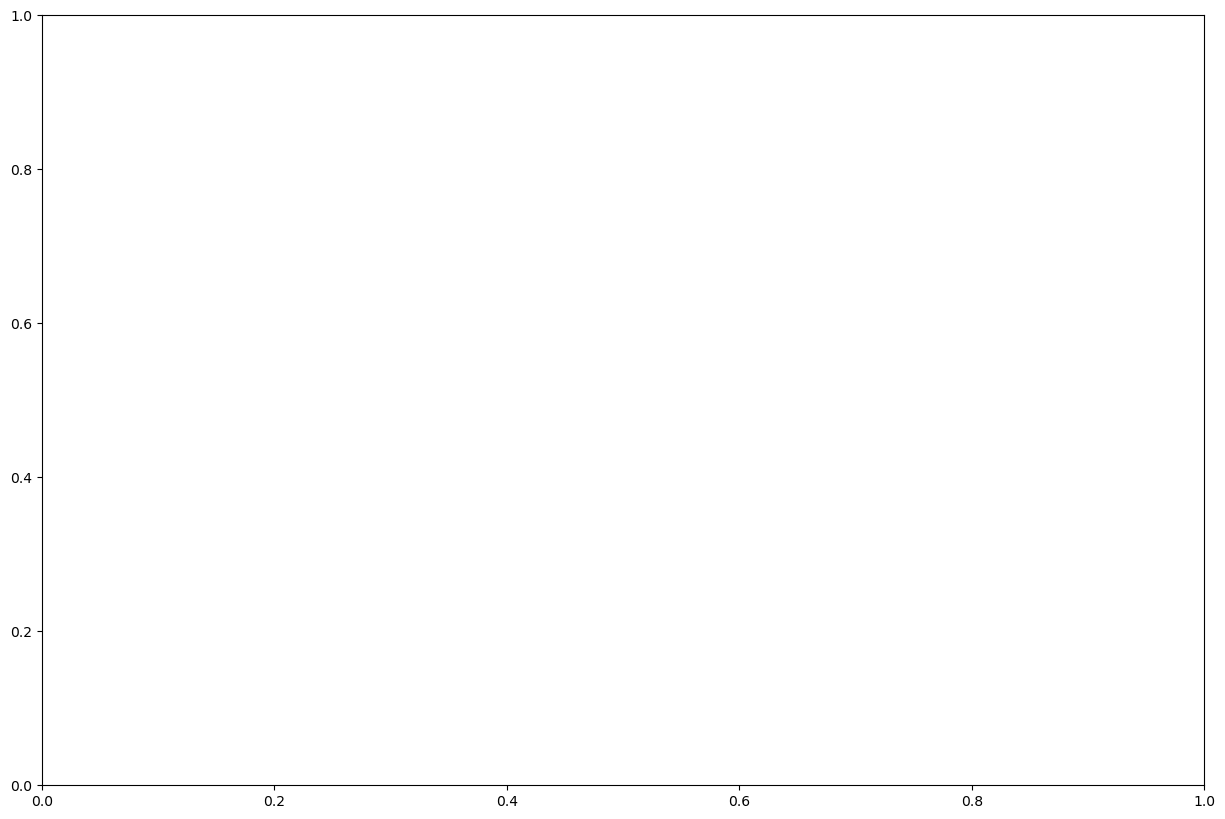

In [31]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

clrs = ['']

b = 'r'
bn = 2

for i,ID in enumerate(ID_selected):
    
    df_new = df1[(df1.object_id == ID) & (df1.passband == bn)].reset_index(drop=True)
   

    if len(df_new.flux)==0:
        print(ID)
        continue
        
    
    f = df_new.flux.values
    ferr = df_new.flux_err.values

    df_new['m'] = -2.5*np.log10(df_new.flux/(10**(-0.4*27.5)))
    df_new['m_err'] = 2.5 / np.log(10) * df_new['flux_err'] / df_new['flux']
    
    
        
    x = df_new.mjd.values
    y = df_new['m'].values
    yerr = df_new['m_err'].values
    
#     x = x - x[np.argmin(y)]
    x_peak = df_r.mjd[np.argmin(df_r.m)]
    y_peak = df_r.m[np.argmin(df_r.m)]

    if ID == 218492:
        low_lim = -20
    else:
        low_lim = -50
        up_lim = 100
    
    ind = (x < up_lim + x_peak) & (x > low_lim + x_peak)
    y = y[ind]
    yerr = yerr[ind]
    x = x[ind]
#     y =  y - y[np.argmin(y)]
    t = np.linspace(x.min(), x.max(), 1000)
    
    if len(y)<4:
        continue
        
#     interpld_min = t[np.argmin(interp1d(x, y, kind='cubic')(t))]
    t_new, func, p0 = lc_fit(np.row_stack((x, f[ind], ferr[ind])))
    m_func = 27.5 - 2.5*np.log10(func)
    if np.sum(np.isinf(m_func))>0:
        print(b, ID)
        continue
    xx = np.linspace(x.min(), x.max(), 1000)
    new_x_peak = xx[m_func == np.nanmin(m_func)]
    new_t_peak = t_new[m_func == np.nanmin(m_func)]
    new_y_peak = np.nanmin(m_func)
        

    
#     max_g[0].append(t[np.argmin(interp1d(x, y, kind='cubic')(t))])
#     max_g[1].append(min(interp1d(x, y, kind='cubic')(t)))
    
    
    if i ==0 :
        ax.errorbar(x - new_x_peak,\
                new_y_peak - y + min(interp1d(x, y, kind='cubic')(t)), yerr=yerr, fmt='o',\
                linewidth=3, color = 'k', label = 'PLASTICC data')
        ax.plot(t_new - new_t_peak,\
                new_y_peak - m_func,\
                '-', linewidth=0.1, color = 'k', label = 'Cubic Interpolation')
    else: 
        ax.errorbar(x - new_x_peak,\
                new_y_peak - y + min(interp1d(x, y, kind='cubic')(t)), yerr=yerr, fmt='o',\
                linewidth=3, color = 'k')
        ax.plot(t_new - new_t_peak,\
                new_y_peak - m_func,\
                '-', linewidth=0.1, color = 'k')
        
    
    

t = t - new_x_peak
t = t[(t>-20) & (t<50)]

for SNTYPE in SNTYPES:
    ax.plot( tmpl[b][SNTYPE]['t'] ,tmpl[b][SNTYPE]['rollingMedian'] ,\
            color = colorTypes[SNTYPE], linewidth = 5, label = SNTYPE + ' GP in '+ b)
    ax.fill_between( tmpl[b][SNTYPE]['t'] , tmpl[b][SNTYPE]['rollingPc75'],\
                    tmpl[b][SNTYPE]['rollingPc25'],\
                    color = colorTypes[SNTYPE], alpha = 0.3)
    
#     ax.plot(t - t[np.argmin(interp1d(x, y, kind='cubic')(t))],\
#             interp1d(x, y, kind='cubic')(t) - min(interp1d(x, y, kind='cubic')(t)))

ax.set_title('GP Templates in '+b+' Band', size=30)

ax.set_ylabel("Normalized mag", size = 30)
ax.set_xlabel("Time (days since the peak)", size = 30)
ax.legend(loc = 'lower center', fontsize=20)
ax.invert_yaxis()
ax.set_ylim(-4,0.3)
ax.set_xlim(-25,55)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

    
# plt.savefig('plastic_GPtmpl_'+b+'.png', bbox_inches='tight')

In [32]:
f

array([-4.40261000e-01, -1.01599800e+00,  3.40749000e-01, -1.30403300e+00,
        7.15786000e-01, -5.57394000e-01, -2.82849000e-01,  6.65053000e-01,
        3.17373000e-01,  2.89050000e-01, -1.27820900e+00,  1.12813600e+00,
       -1.42252600e+00,  1.19441200e+00, -2.14572000e-01,  8.19860000e-02,
        3.88070000e-01,  8.88814000e-01, -3.36356000e-01, -3.83545000e-01,
        3.69914000e-01,  8.71459000e-01, -1.64770000e-02,  2.14637900e+00,
        8.58590000e-02, -5.75050000e-02, -2.46414800e+00,  6.52253000e-01,
        1.17100000e-01, -1.03015000e-01, -9.51253000e-01,  8.03720000e-02,
       -3.02360000e-01, -2.71466000e-01,  6.75170000e-02,  1.68767000e-01,
       -8.49620000e-02,  5.37642100e+01,  4.74901154e+02,  4.12128693e+02,
        2.78817017e+02,  2.53222580e+02,  2.35727325e+02,  1.86898727e+02,
        1.67212906e+02,  9.73428800e+01,  8.15986560e+01,  7.66918330e+01,
        6.98521880e+01,  5.12970280e+01,  4.64008790e+01,  3.64086230e+01,
        3.25514980e+01,  

In [33]:
# df3 = pd.DataFrame({'ID': good_sn, 'JDmax_u': np.zeros(len(good_sn)), 'JDmax_g': np.zeros(len(good_sn)),\
#                                    'JDmax_r': np.zeros(len(good_sn)), 'JDmax_i': np.zeros(len(good_sn))})

# # df3.to_csv('good_Ibc_sn_peaks.csv')

In [34]:

# for ID in IDs:
# #     print(ID)
#     plt.figure(figsize=(15,10))
#     for b in [2]:
#         df_new = df1[(df1.object_id == ID) & (df1.passband == b)].reset_index(drop=True)
#         df_new = df_new[df_new.flux>0].reset_index(drop=True)

#         if len(df_new.flux)==0:
#             print(ID)
#             continue


#         df_new['m'] = -2.5*np.log10(df_new.flux/(10**(-0.4*27.5)))
#         median = np.nanmedian(df_new['m'])
#         df_new['m'] = df_new['m']- median
#         df_new['m_err'] = 2.5 / np.log(10) * df_new['flux_err'] / df_new['flux']

#     #     print(df_new)

#         plt.errorbar(df_new.mjd-df_new.mjd[np.argmax(df_new.flux)],
#                      df_new.flux - np.max(df_new.flux),
#                      yerr = df_new.flux_err, fmt='o')
#         plt.title(ID)
# #     plt.savefig(ID+'.png')
#         # plt.ylim(-15,5)

# # print(np.median(df_new.flux_err/ df_new.flux))

/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/Plasticc_I/Functions.py:88: RuntimeWarning: overflow encountered in square
  return (np.sum((f-model)**2*inv_sigma2))
/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/Plasticc_I/Functions.py:70: RuntimeWarning: overflow encountered in power
  exp_rise = np.e**(np.asarray(shift * (t - t0))) + 1


(-50.0, 100.0)

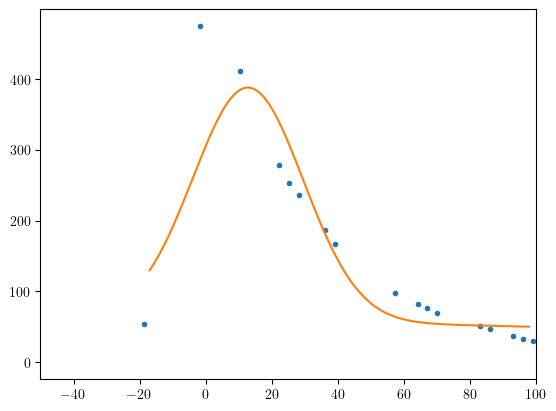

In [50]:
ID = 19213
b = 2
df_new = df1[(df1.object_id == ID) & (df1.passband == b)].reset_index(drop=True)
df_r = df1[(df1.object_id == ID) & (df1.passband == 2)].reset_index(drop=True)

f = df_new.flux[df_new.flux>0].values
ferr = df_new.flux_err[df_new.flux>0].values

x = df_new.mjd[df_new.flux>0].values
y = 27.5 - 2.5*np.log10(f)
yerr = 2.5 / np.log(10) * ferr / f

x_peak = df_r.mjd.values[np.argmax(df_r.flux)] + coffset[bb[b]]
x_peak2 = x[np.argmax(f)]
y_peak = min(y)

t_new, func, p0 = lc_fit(np.row_stack((x, f, ferr)), x_peak= x_peak2)

    
m_func = 27.5 - 2.5*np.log10(func)

plt.plot(x-x_peak, f, '.')
plt.plot(t_new, func)
plt.xlim(-50,100)

In [45]:
y

array([        nan,         nan, 28.66891353,         nan, 27.863042  ,
               nan,         nan, 27.94285936, 28.74607506, 28.84756757,
               nan, 27.36909635,         nan, 27.3071146 ,         nan,
       30.21565075, 28.52772482, 27.62797278,         nan,         nan,
       28.57974808, 27.6493826 ,         nan, 26.67073397, 30.16553544,
               nan,         nan, 27.96395979, 29.82860776,         nan,
               nan, 30.23723806,         nan,         nan, 30.42646716,
       29.43178117,         nan, 23.17376683, 20.80849194, 20.96241787,
       21.38670181, 21.49124393, 21.56897518, 21.82098414, 21.94182551,
       22.52923952, 22.72079249, 22.78812721, 22.88954996, 23.22476949,
       23.33368448, 23.59698937, 23.71857255, 23.83173002, 24.16083592,
       24.29996611])

In [36]:
clrs = {}

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_94108/4008611680.py:78: RuntimeWarning: invalid value encountered in log10
  m_func = 27.5 - 2.5*np.log10(func)
/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/Plasticc_I/Functions.py:88: RuntimeWarning: overflow encountered in square
  return (np.sum((f-model)**2*inv_sigma2))
/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/Plasticc_I/Functions.py:82: RuntimeWarning: overflow encountered in multiply
  return exp_fit(t, t0, shift) * (gaussian + linear)
/Users/somayeh/opt/anaconda3/envs/pyt38/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


190878 u 9.660267567567644 0.8796160163391811
[6.36026757] 0.8796160163391811
[60173.9726 60194.969  60195.9186 60196.9139 60197.9072 60198.9089
 60258.755  60260.7559 60261.778  60286.7761 60287.7689 60289.7699]
190878 g 10.729252452452783 1.6699234185250624
[36.13514755] 1.6699234185250624


/Users/somayeh/opt/anaconda3/envs/pyt38/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2884: RuntimeWarning: invalid value encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


190878 r 2.950936036031635 0.058151905126806014
[8.12316396] 0.058151905126806014
190878 i 1.1128828828805126 0.040092410176622906
[8.68678288] 0.040092410176622906


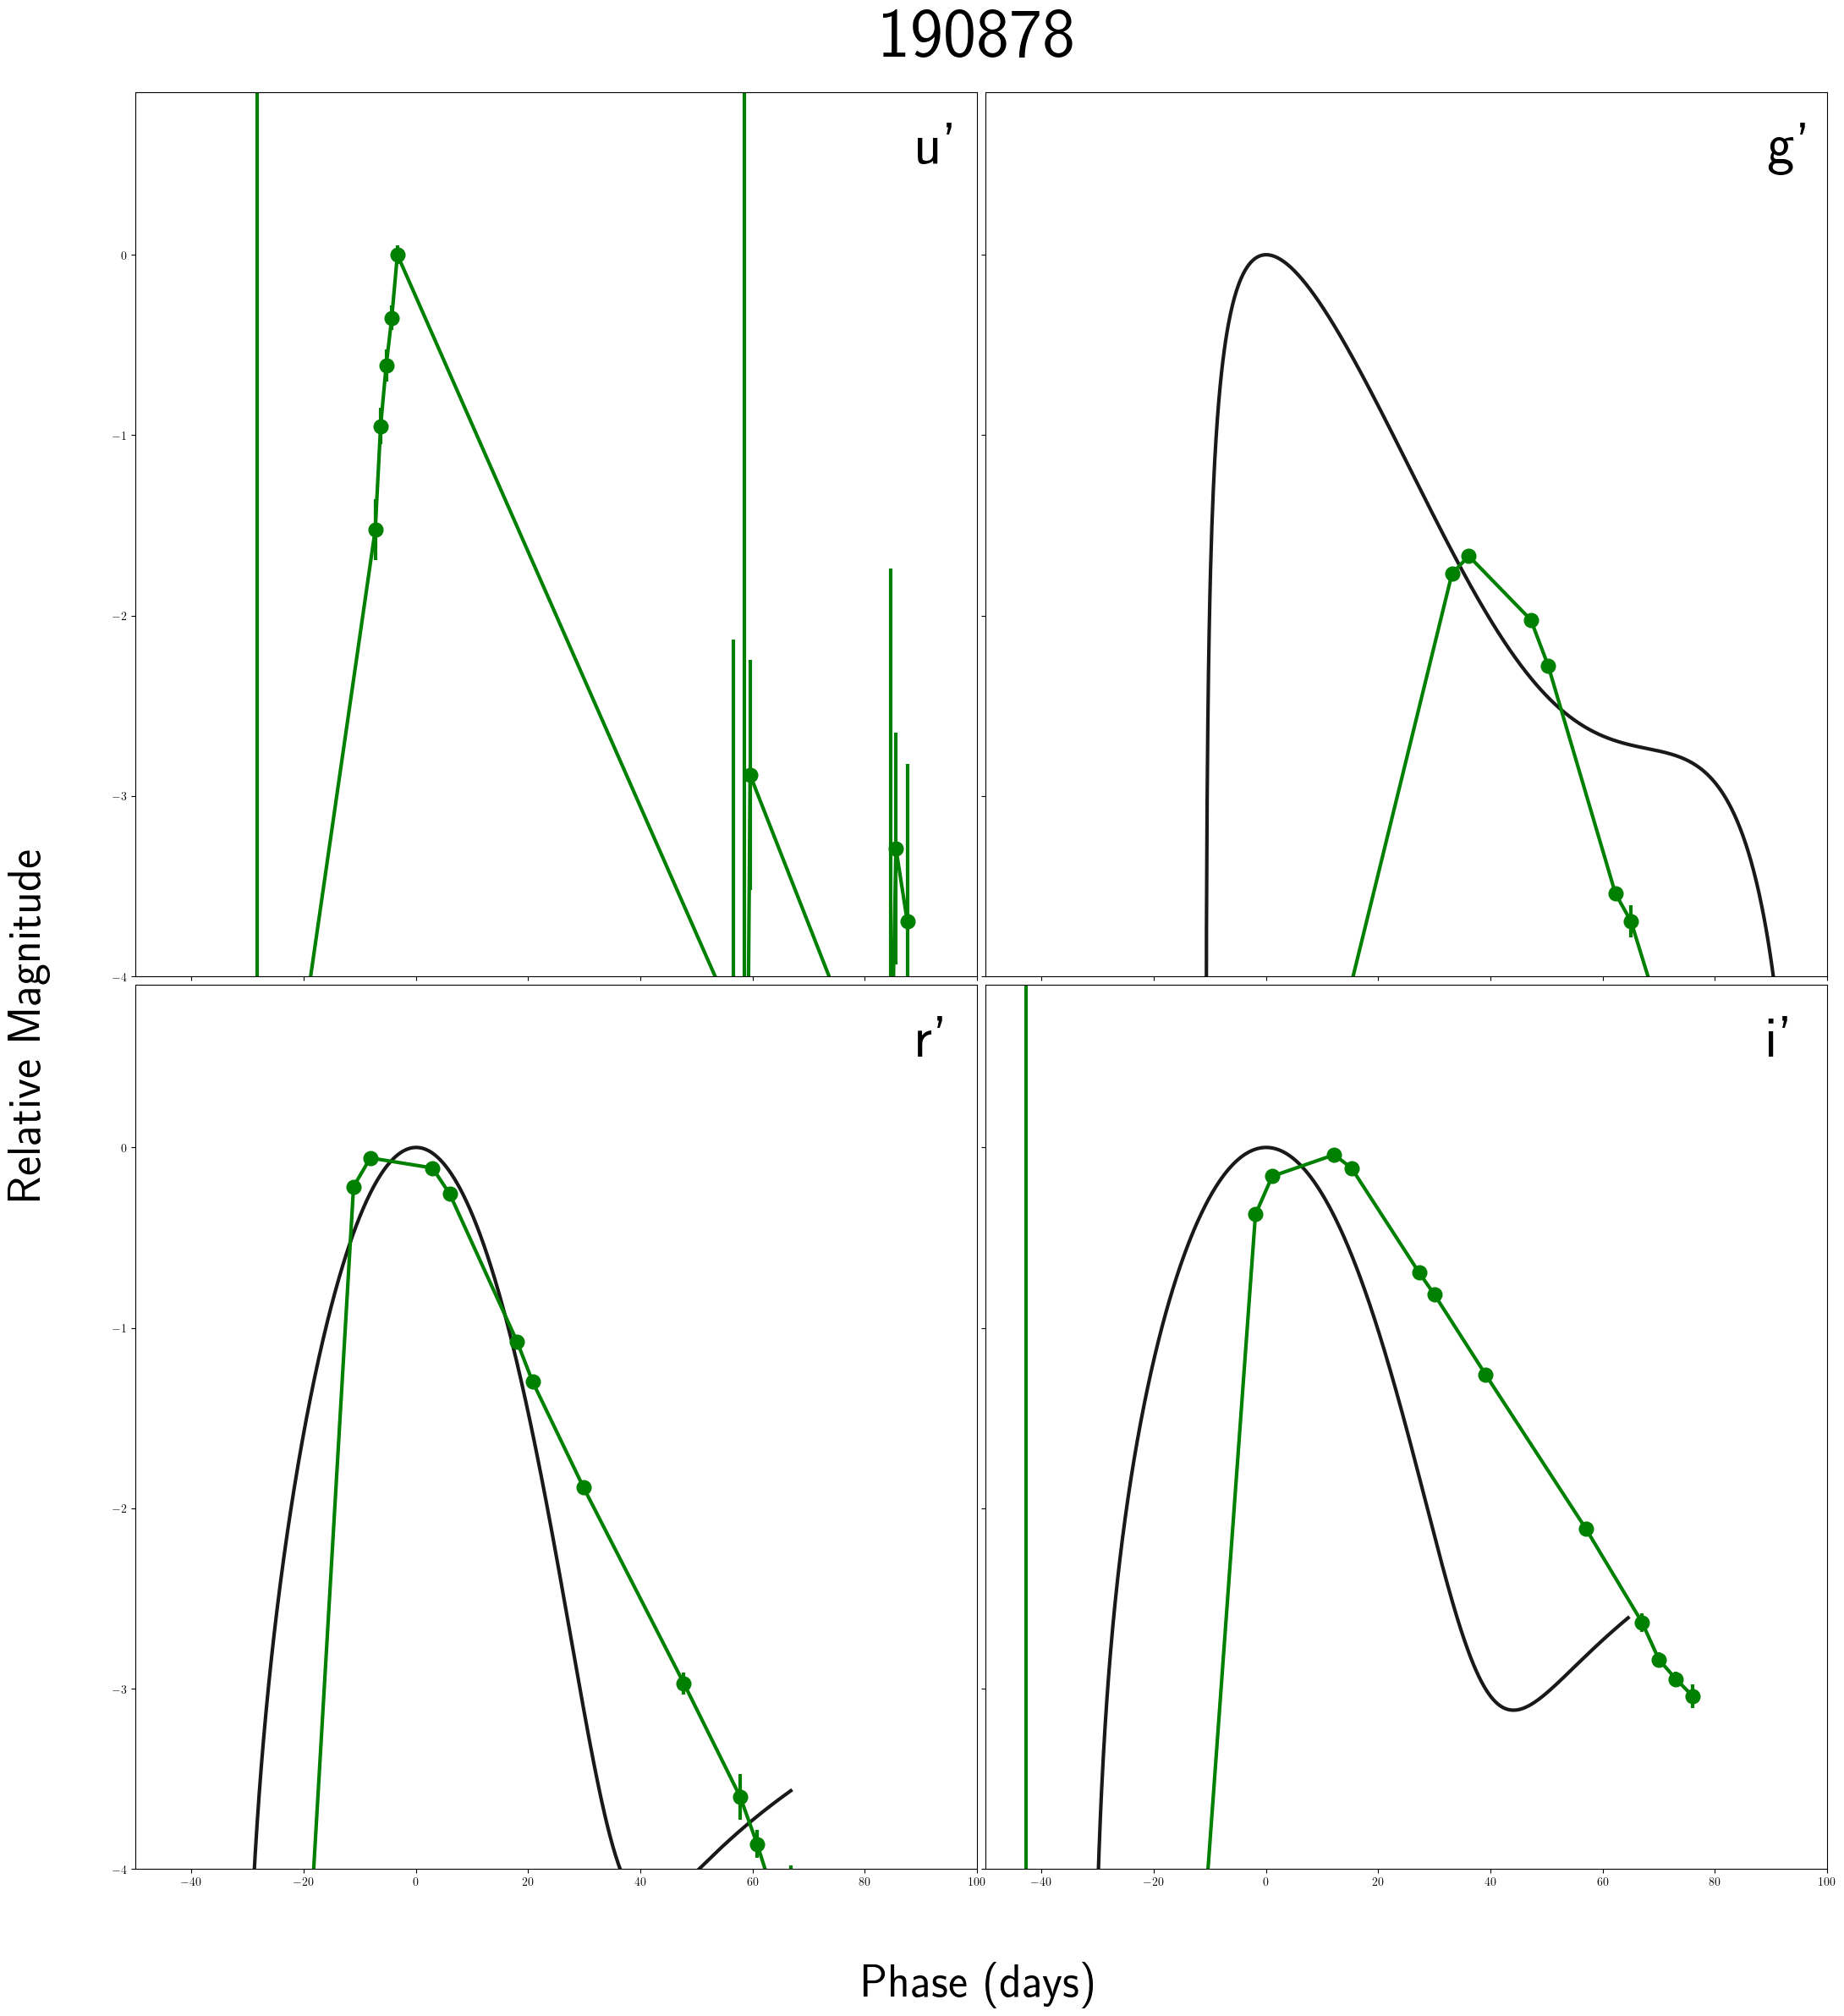

In [72]:
# ugrizy = 012345
bb = ['u','g','r','i']
ID = 26842116
b_ = [0,1,2,3]

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']



# u, g, r, i

max_u = [[],[]]
max_g = [[],[]]
max_r = [[],[]]
max_i = [[],[]]


plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'

# print(band_sntypes)


    
for i,ID in enumerate([190878]):
    fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(25,25))
    
    for b in b_: 

        df_new = df1[(df1.object_id == ID) & (df1.passband == b)].reset_index(drop=True)
        df_r = df1[(df1.object_id == ID) & (df1.passband == 2)].reset_index(drop=True)


        if len(df_new.flux)==0:
            print(ID)
            continue


        f = df_new.flux[df_new.flux>0].values
        ferr = df_new.flux_err[df_new.flux>0].values

        x = df_new.mjd[df_new.flux>0].values
        y = 27.5 - 2.5*np.log10(f)
        yerr = 2.5 / np.log(10) * ferr / f

    #     x = x - x[np.argmin(y)]
        x_peak = df_r.mjd.values[np.argmax(df_r.flux)] + coffset[bb[b]]
        x_peak2 = x[np.argmax(f)]
        y_peak = min(y)

#         if np.sum(np.abs(x - x_peak)<20) < 4:
#             continue

        if ID == 218492:
            low_lim = -20
        else:
            low_lim = -50
            up_lim = 100

        ind = (x < up_lim + x_peak) & (x > low_lim + x_peak)
        y = y[ind]
        yerr = yerr[ind]
        x = x[ind]
    #     y =  y - y[np.argmin(y)]
        if len(y)<4:
            continue
        t = np.linspace(x.min(), x.max(), 1000)



    #     interpld_min = t[np.argmin(interp1d(x, y, kind='cubic')(t))]
        try:
            t_new, func, p0 = lc_fit(np.row_stack((x, f[ind], ferr[ind])), x_peak= x_peak2)
        except:
            print(ID, b)
            continue
        m_func = 27.5 - 2.5*np.log10(func)
        if np.sum(np.isinf(m_func))>0:
            print(b, ID)
            continue
        xx = np.linspace(x.min(), x.max(), 1000)
        new_x_peak = xx[func == np.nanmax(func)]
        new_t_peak = t_new[m_func == np.nanmin(m_func)]
        new_y_peak = np.nanmin(m_func)


        if b!=2:
            x = x + coffset[bb[b]]
        print(ID,bb[b], np.min(np.abs(x - new_x_peak)), np.min(np.abs(new_y_peak - y)))
        print(np.abs(new_x_peak-x_peak2), np.abs(new_y_peak-np.min(y)))

        if b == 0:
            print(x)

            np.concatenate(ax)[b].errorbar(x-x_peak2,\
                 np.min(y) - y, yerr=yerr, fmt='o-', \
                linewidth = 3, markersize = 12, color = 'g', label = r'$\mathrm{Plasticc } \; \mathrm{ light curves}$')
#             np.concatenate(ax)[b].plot(t_new - new_t_peak,\
#                 new_y_peak - m_func,\
#                 '-', linewidth = 3, color = 'k', alpha = 0.9, label = 'VL fit')


        else:
            np.concatenate(ax)[b].errorbar(x - new_x_peak,\
                new_y_peak - y, yerr=yerr, fmt='o-',\
                linewidth = 3, markersize =12, color = 'g')
            np.concatenate(ax)[b].plot(t_new - new_t_peak,\
                new_y_peak - m_func,\
                '-', linewidth = 3, color = 'k', alpha = 0.9)
        np.concatenate(ax)[b].text(0.93, 0.92, bb[b]+"'", transform=np.concatenate(ax)[b].transAxes,\
                               weight='bold', size = 50, color = 'k')
            
#     handles, labels = np.concatenate(ax)[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center', ncol=3, prop={'size':35})
#     np.concatenate(ax)[0].set_yticklabels(['','-7', '-6','-5', '-4', '-3','-2', '-1', '0'], size=30)
#     np.concatenate(ax)[2].set_yticklabels(['','-7', '-6', '-5', '-4', '-3','-2', '-1', '0'], size=30)

#     np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=30)
#     np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '10', '20', '30', '40', '50', ''], size=30)


    np.concatenate(ax)[0].set_xlim(-50,100)
    np.concatenate(ax)[0].set_ylim(-4,0.9)
    fig.suptitle(ID, size = 60)
    fig.subplots_adjust(top=0.94, hspace = 0.01, wspace = 0.01, left = 0.1, bottom = 0.1)
    fig.text(0.5, 0.04, 'Phase (days)', ha='center', size = 40)
    fig.text(0.04, 0.5, 'Relative Magnitude', va='center', rotation='vertical', size = 40)


#     fig.save

19213 u 0.31379999999626307 0.0016028351249275374
34299 u 0.3427000000010594 0.014770959832560493
42118 u 0.6302296296344139 0.041804775743770506
49529 u 10.524107507502777 0.10016373235562881
55419 u 3.3000000000029104 0.008340906054613129
69767 u 1.8737032032004208 0.0022531106411669555
190161 u 11.049733633633878 0.012736501727690808
190878 u 9.660267567567644 0.8796160163391811
197650 u 5.551710810810619 0.17193251535132248
232308 u 0.6928999999945518 0.08581998449893291


/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_94108/846530141.py:75: RuntimeWarning: invalid value encountered in log10
  m_func = 27.5 - 2.5*np.log10(func)


263344 u 5.84636036035954 0.019920326094602814
292021 u 0.28809369368536863 10.615765439638327
331538 u 10.275302702699264 0.12607525037424594
340269 u 10.293764264257334 0.5959165749494097
162093 u 5.091238438435539 0.05583275721364345
203563 u 7.518548148153059 0.49490041177288546
29670 g 1.1473643643621472 0.03235474469426336
34299 g 0.3612012012017658 0.0038476843623698187
42118 g 2.3683239239253453 0.05461807429296428
49529 g 2.4727098098082934 0.005664687097898025
69767 g 4.555443943936552 0.07079837605270001
87180 g 1.4197447447440936 0.09933848103752396
183932 g 1.3595732732792385 0.11519962936595363
190161 g 0.788086386382929 0.07538100884778132
190577 g 5.201445945946034 0.026157556966275308
190878 g 10.729252452452783 1.6699234185250624
197650 g 4.015475975975278 0.009956848385122896
218492 g 4.395338738737337 0.4458688098353569
232308 g 2.114226726727793 0.01904554303554562
263344 g 0.11578738738171523 0.059875282925563766
292021 g 0.11398768769140588 0.10600372367366617
30

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_94108/846530141.py:74: RankWarning: Polyfit may be poorly conditioned
  t_new, func, p0 = lc_fit(np.row_stack((x, f[ind], ferr[ind])), x_peak= x_peak2)


40179498 r 7.737872672674712 0.22261670963972335
47232343 r 2.086129829833226 0.051374038079440965
63730187 r 2.975102802804031 0.0766865391599012
90164039 r 0.2936048048068187 0.05356448005266756
104304755 r 5.585622422418965 0.022138241692328364
44537206 r 2.1777285285279504 0.029360259226809404
74516761 r 0.14678978978918167 0.004388299972067244
119547853 r 2.72097057056817 0.042429967947459346


/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_94108/846530141.py:74: RankWarning: Polyfit may be poorly conditioned
  t_new, func, p0 = lc_fit(np.row_stack((x, f[ind], ferr[ind])), x_peak= x_peak2)


162093 r 3.6835594594595022 0.004178266218573867
203563 r 2.6676129129191395 0.10624417215318971


/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_94108/846530141.py:74: RankWarning: Polyfit may be poorly conditioned
  t_new, func, p0 = lc_fit(np.row_stack((x, f[ind], ferr[ind])), x_peak= x_peak2)


105345794 r 3.0813038038031664 0.03313730902781131
29670 i 2.94730280280055 0.13903557356816876
34299 i 0.048218618612736464 0.003637126146539771
42118 i 0.4359412412450183 0.01873891523570137
49529 i 1.8091819819819648 0.04586302321968816
69767 i 0.4467999999978929 0.1459400359926697
87180 i 0.5017000000007101 0.002570749927635063
183932 i 2.0208286286288057 0.00615763548302084
190161 i 0.2669813813845394 0.08148528244657527
190577 i 2.3568602602608735 0.0047812082749949525
190878 i 1.1128828828805126 0.040092410176622906
197650 i 2.3318629629648058 0.010642921449754539
218492 i 3.8974531531566754 0.16613824149678535
232308 i 12.707774374372093 0.02385128844860418
263344 i 0.552800000004936 0.1521163817318154
292021 i 1.082847947945993 0.011939080203529073
305218 i 0.956717317312723 0.044476540662412134
331538 i 0.5043000000005122 0.04069335740149427
332613 i 3.5 0.04087402340019253
340269 i 1.4552147147114738 0.07232581734604437
90509277 i 2.2391549549574847 0.03974073776735665
44537

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_94108/846530141.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[0].set_yticklabels(['','-7', '-6','-5', '-4', '-3','-2', '-1', '0'], size=30)
/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_94108/846530141.py:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[2].set_yticklabels(['','-7', '-6', '-5', '-4', '-3','-2', '-1', '0'], size=30)
/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_94108/846530141.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=30)
/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_94108/846530141.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '

Text(0.04, 0.5, 'Relative Magnitude')

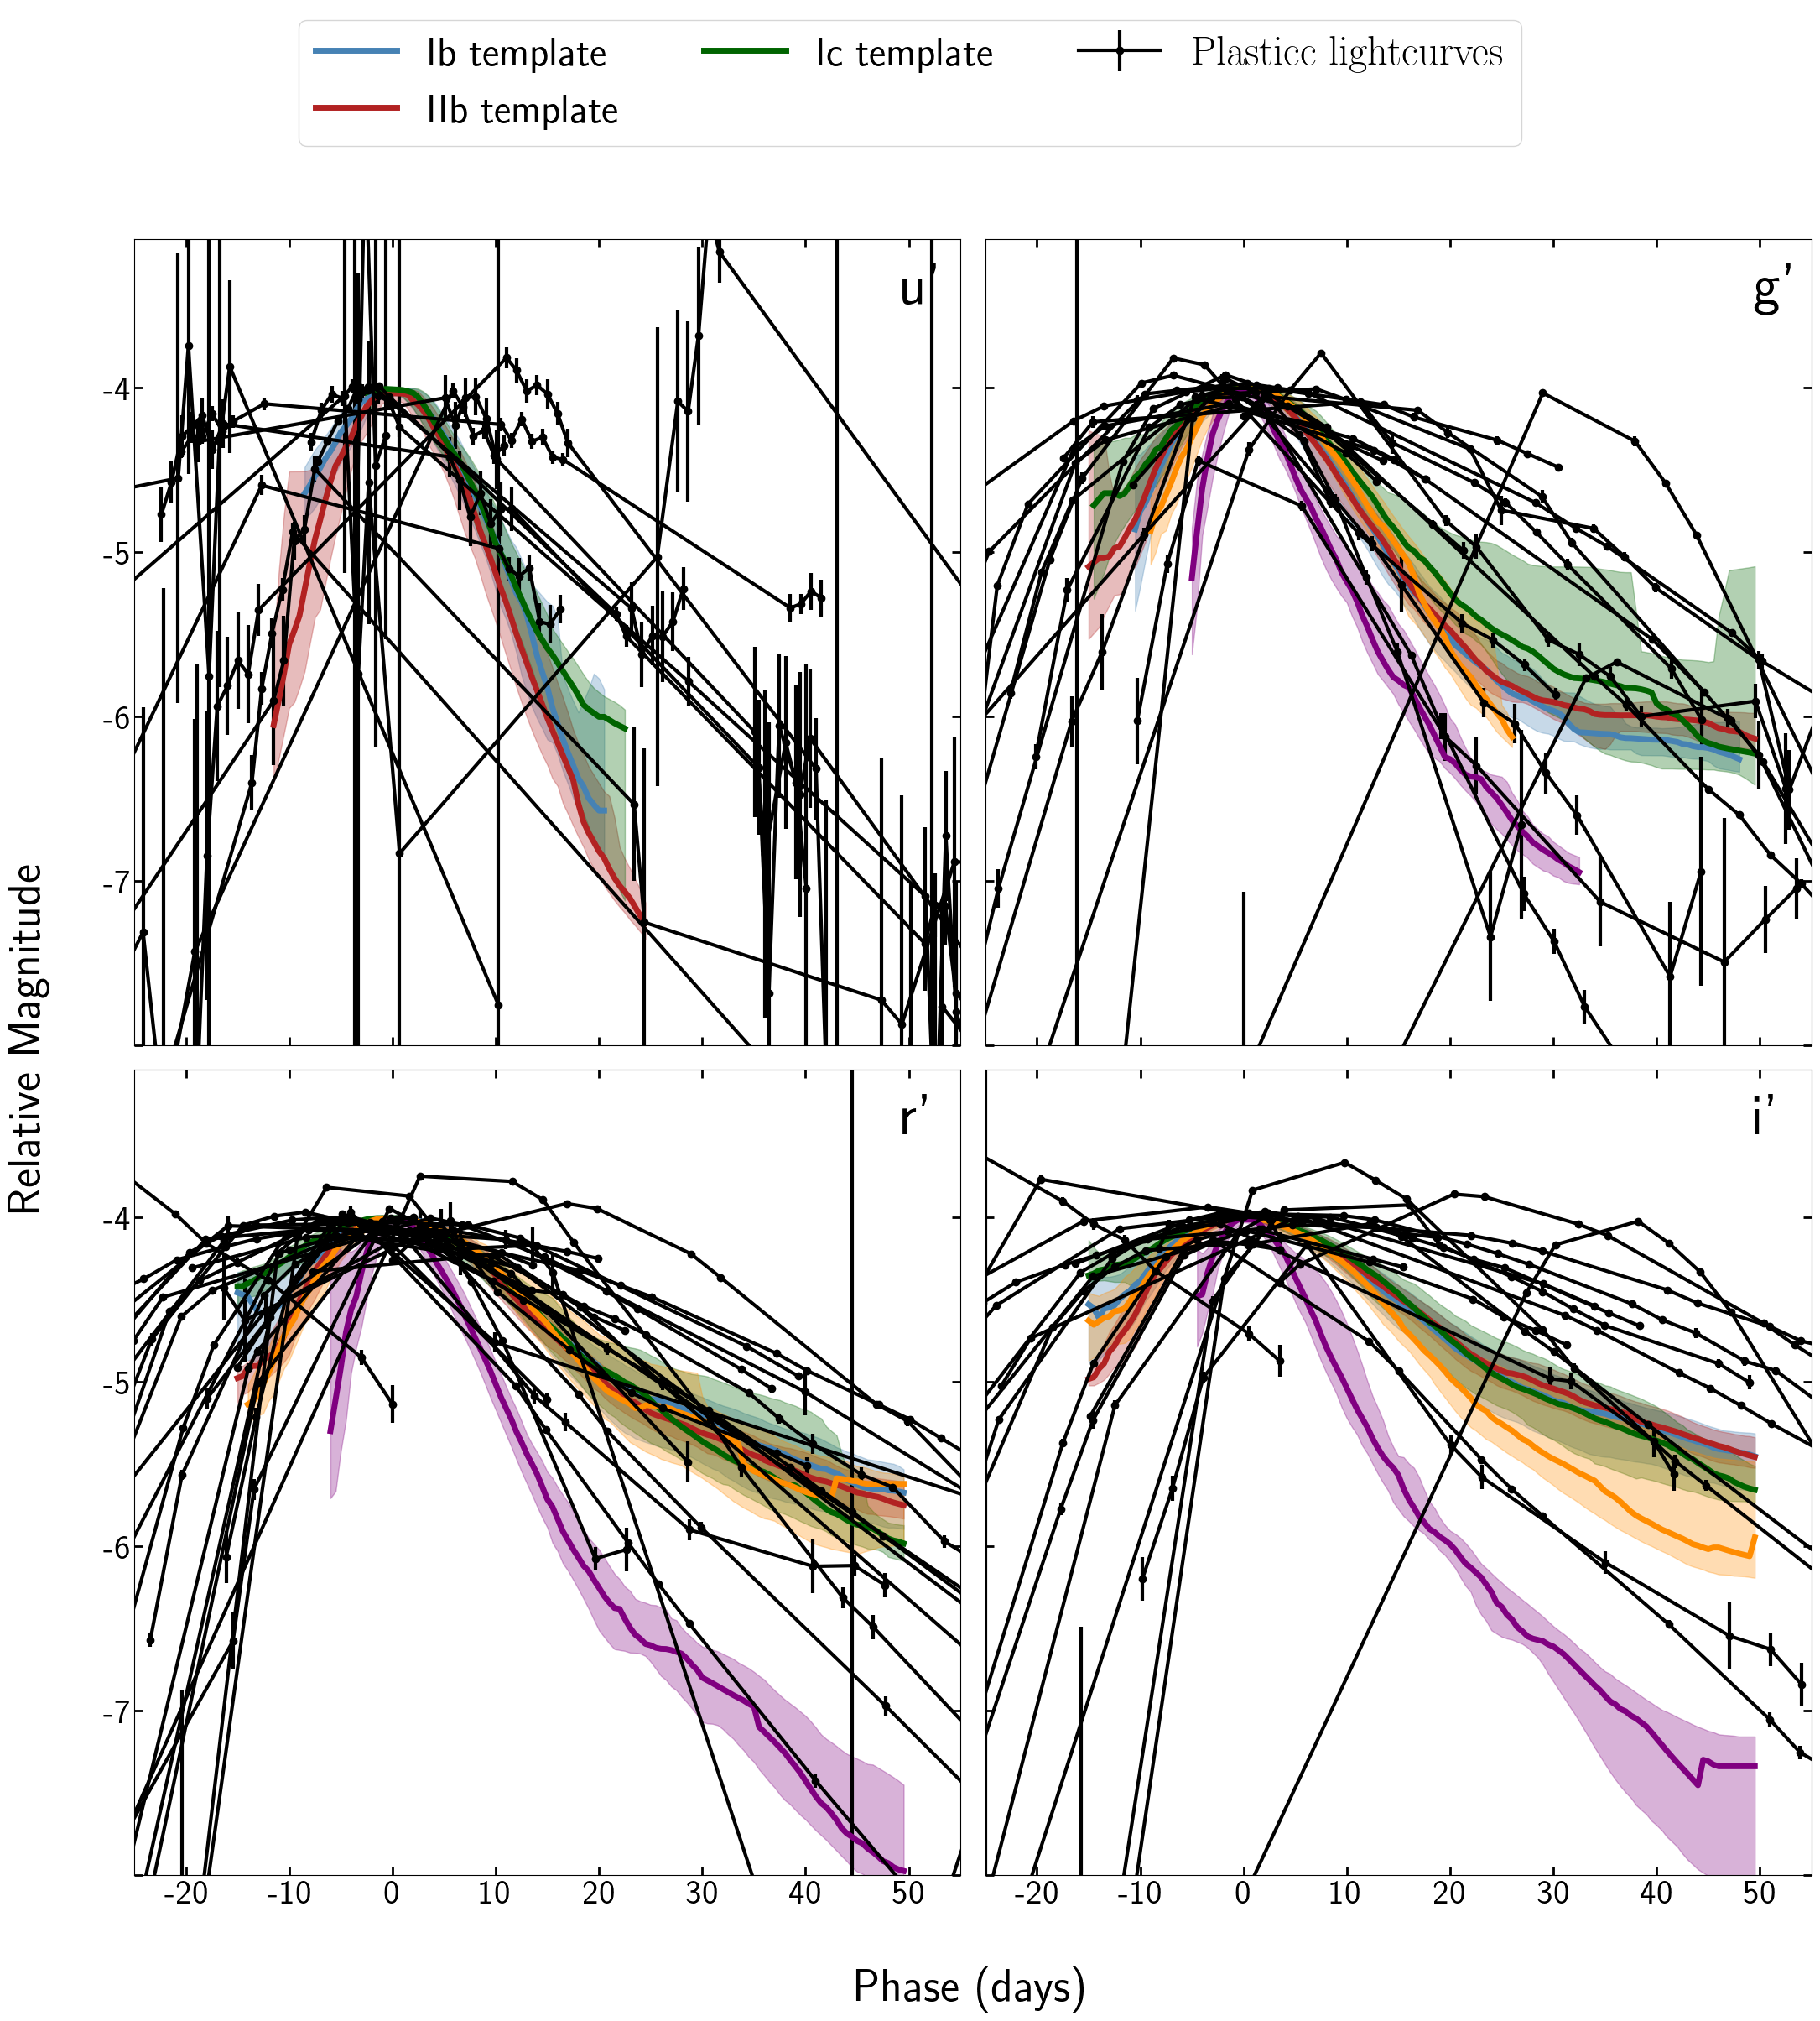

In [80]:
# ugrizy = 012345
bb = ['u','g','r','i']
ID = 26842116
b_ = [0,1,2,3]

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']



# u, g, r, i

max_u = [[],[]]
max_g = [[],[]]
max_r = [[],[]]
max_i = [[],[]]


plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'

# print(band_sntypes)
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(25,25))

diff_u, diff_g, diff_r, diff_i = [], [], [], []

for b in b_: 
    band_sntypes = [*tmpl[bb[b]]]
    
    for i,ID in enumerate(ID_selected):

        df_new = df1[(df1.object_id == ID) & (df1.passband == b)].reset_index(drop=True)
        df_r = df1[(df1.object_id == ID) & (df1.passband == 2)].reset_index(drop=True)
   

        if len(df_new.flux)==0:
            print(ID)
            continue


        f = df_new.flux[df_new.flux>0].values
        ferr = df_new.flux_err[df_new.flux>0].values

        x = df_new.mjd[df_new.flux>0].values
        y = 27.5 - 2.5*np.log10(f)
        yerr = 2.5 / np.log(10) * ferr / f

    #     x = x - x[np.argmin(y)]
        x_peak = df_r.mjd.values[np.argmax(df_r.flux)] + coffset[bb[b]]
        x_peak2 = x[np.argmax(f)]
        y_peak = min(y)

        if np.sum(np.abs(x - x_peak)<20) < 4:
            continue

        if ID == 218492:
            low_lim = -20
        else:
            low_lim = -50
            up_lim = 100

        ind = (x < up_lim + x_peak) & (x > low_lim + x_peak)
        y = y[ind]
        yerr = yerr[ind]
        x = x[ind]
    #     y =  y - y[np.argmin(y)]
        if len(y)<4:
            continue
        t = np.linspace(x.min(), x.max(), 1000)

        

    #     interpld_min = t[np.argmin(interp1d(x, y, kind='cubic')(t))]
        t_new, func, p0 = lc_fit(np.row_stack((x, f[ind], ferr[ind])), x_peak= x_peak2)
        m_func = 27.5 - 2.5*np.log10(func)
        if np.sum(np.isinf(m_func))>0:
            print(b, ID)
            continue
        xx = np.linspace(x.min(), x.max(), 1000)
        new_x_peak = xx[func == np.nanmax(func)]
        new_t_peak = t_new[m_func == np.nanmin(m_func)]
        new_y_peak = np.nanmin(m_func)
        
        if b!=2:
            x = x + coffset[bb[b]]
            
        print(ID,bb[b], np.min(np.abs(x - new_x_peak)), np.min(np.abs(new_y_peak - y)))
        
        if np.min(np.abs(x - new_x_peak))>20:
            
            color_ = 'red'
        else:
            color_= 'k'
            
        if ID == 292021:
            y = y-np.min(y)

        
        
        
        
        if i == 0:

            np.concatenate(ax)[b].errorbar(x - new_x_peak,\
                new_y_peak - y, yerr=yerr, fmt='o-',\
                linewidth = 3, color = color_, label = r'$\mathrm{Plasticc } \; \mathrm{ light curves}$')
#             np.concatenate(ax)[b].plot(t_new - new_t_peak,\
#                 new_y_peak - m_func,\
#                 '-', linewidth = 0.1, color = 'r', alpha = 0.5, label = 'VL fit')
                                       
                    
        else:
            np.concatenate(ax)[b].errorbar(x - new_x_peak,\
                new_y_peak - y, yerr=yerr, fmt='o-',\
                linewidth = 3, color = color_
                                          )
#             np.concatenate(ax)[b].plot(t_new - new_t_peak,\
#                 new_y_peak - m_func,\
#                 '-', linewidth = 0.1, color = 'r', alpha = 0.5)


    for tp in band_sntypes:
        if b == 0:
            try:
                if tp == 'Ib':
                    up_lim = 55
                else:
                    up_lim = 55

                np.concatenate(ax)[b].plot(tmpl[bb[b]][tp]['t'][tmpl[bb[b]][tp]['t']<up_lim],\
                        tmpl[bb[b]][tp]['rollingMedian'][tmpl[bb[b]][tp]['t']<up_lim],\
                        '-',color = colorTypes[tp],linewidth=5, label = tp + ' template')
                np.concatenate(ax)[b].fill_between(tmpl[bb[b]][tp]['t'][tmpl[bb[b]][tp]['t']<up_lim],\
                        tmpl[bb[b]][tp]['rollingPc25'][tmpl[bb[b]][tp]['t']<up_lim],\
                        tmpl[bb[b]][tp]['rollingPc75'][tmpl[bb[b]][tp]['t']<up_lim],\
                        alpha = 0.3, color = colorTypes[tp])
            except:
                pass 
        else:
            
            
            try:
                if b == 1 and tp == 'Ic':

                    np.concatenate(ax)[b].plot(tmpl[bb[b]][tp]['t'][tmpl[bb[b]][tp]['t']<55],\
                            tmpl[bb[b]][tp]['rollingMedian'][tmpl[bb[b]][tp]['t']<55],\
                            '-',color = colorTypes[tp],linewidth=5)
                    np.concatenate(ax)[b].fill_between(tmpl[bb[b]][tp]['t'][tmpl[bb[b]][tp]['t']<55],\
                            tmpl[bb[b]][tp]['rollingPc25'][tmpl[bb[b]][tp]['t']<55],\
                            tmpl[bb[b]][tp]['rollingPc75'][tmpl[bb[b]][tp]['t']<55],\
                            alpha = 0.3, color = colorTypes[tp])
                
                else:
                    np.concatenate(ax)[b].plot(tmpl[bb[b]][tp]['t'],\
                            tmpl[bb[b]][tp]['rollingMedian'],\
                            '-',color = colorTypes[tp],linewidth=5)
                    np.concatenate(ax)[b].fill_between(tmpl[bb[b]][tp]['t'],\
                            tmpl[bb[b]][tp]['rollingPc25'],\
                            tmpl[bb[b]][tp]['rollingPc75'],\
                            alpha = 0.3, color = colorTypes[tp])
            except:
                    pass 

    #     plt.title('Plasticc I light curves compared with GP templates in ' + str(bb) + ' band', size=30)
        
#         plt.legend(loc = 'lower left', ncol=3, prop={'size':30})
        np.concatenate(ax)[b].tick_params(axis="both", direction="in", which="major",\
                                              right=True, top=True, size=7, labelsize=25, width = 2)
    
    np.concatenate(ax)[b].text(0.93, 0.92, bb[b]+"'", transform=np.concatenate(ax)[b].transAxes,\
                               weight='bold', size = 50, color = 'k')
    
handles, labels = np.concatenate(ax)[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, prop={'size':35})
np.concatenate(ax)[0].set_yticklabels(['','-7', '-6','-5', '-4', '-3','-2', '-1', '0'], size=30)
np.concatenate(ax)[2].set_yticklabels(['','-7', '-6', '-5', '-4', '-3','-2', '-1', '0'], size=30)

np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=30)
np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '10', '20', '30', '40', '50', ''], size=30)


np.concatenate(ax)[0].set_xlim(-25,55)
np.concatenate(ax)[0].set_ylim(-4,0.9)
plt.subplots_adjust(hspace=.03, wspace=0.03, top = 0.88, left = 0.1, bottom = 0.1)

fig.text(0.5, 0.04, 'Phase (days)', ha='center', size = 40)
fig.text(0.04, 0.5, 'Relative Magnitude', va='center', rotation='vertical', size = 40)


# plt.savefig('plasticc_gp_tmpl_ugri_high_SN_peak_covered5.pdf', bbox_inches='tight')

In [93]:
m = np.zeros((3,3,3,1))

In [99]:
m[0, :,:] = np.asarray([[3,3,3],[32,1,2], [4,3,3]]).reshape((3,3,1))

m[0

In [100]:
m[0]

array([[[ 3.],
        [ 3.],
        [ 3.]],

       [[32.],
        [ 1.],
        [ 2.]],

       [[ 4.],
        [ 3.],
        [ 3.]]])